In [3]:
!pip install rasterio albumentations
!pip install torchvision segmentation-models-pytorch

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 22.2/22.2 MB 72.1 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.7 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.9 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 2.2 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 31.2 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 13.6 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 8.3 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 71.0 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.8/154.8 kB 13.6 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.8.93
    Uninstalling nvidia-nvjitlink-cu12-12.8.93:
      Successfully uninstalled n

In [4]:
# Standard libraries
import os
import shutil
import numpy as np
import matplotlib.pyplot as plt

# PyTorch
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms.functional as TF

# Image I/O and processing
import cv2
import rasterio
import tifffile as tiff
import seaborn as sns
import pandas as pd

# Data augmentation and transforms
import albumentations as A
from albumentations import (
    HorizontalFlip, VerticalFlip, RandomBrightnessContrast, Rotate, Resize, Normalize, Compose,RandomRotate90, GaussNoise
)
from albumentations.pytorch import ToTensorV2
import torch.nn.functional as F

# Model and segmentation
import segmentation_models_pytorch as smp

# Utilities
from sklearn.model_selection import train_test_split
from tqdm import tqdm


/usr/local/lib/python3.11/dist-packages/albumentations/__init__.py:28: UserWarning: A new version of Albumentations is available: '2.0.6' (you have '2.0.4'). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()


# Test Image Visualization

In [5]:
# Display image and mask pairs
plt.figure(figsize=(12, 12))

image_path = '/kaggle/input/cloud-masking-dataset/content/train/data/502686.tif'
mask_path = '/kaggle/input/cloud-masking-dataset/content/train/masks/502686.tif'

# Load image and mask
image = tiff.imread(image_path)  # shape: (H, W, 4)
mask = tiff.imread(mask_path)

# Extract RGB channels only
rgb_image = image[:, :, :3]
# Normalize image if values are outside [0, 1] or [0, 255]
if rgb_image.dtype != np.uint8:
    rgb_image = rgb_image.astype(np.float32)
    rgb_image = (rgb_image - rgb_image.min()) / (rgb_image.max() - rgb_image.min())

# Plot RGB image
plt.subplot(5, 2, 1)
plt.imshow(rgb_image)
plt.title(f'Image')
plt.axis('off')
# Plot corresponding mask
plt.subplot(5, 2, 2)
plt.imshow(mask, cmap='gray',vmax= 1,vmin = 0)
plt.title('Mask')
plt.axis('off')
# Extract RGB channels only
rgb_image = image[:, :, :3]
print(rgb_image.shape)
plt.tight_layout()
plt.show()

(512, 512, 3)


# Correlation test

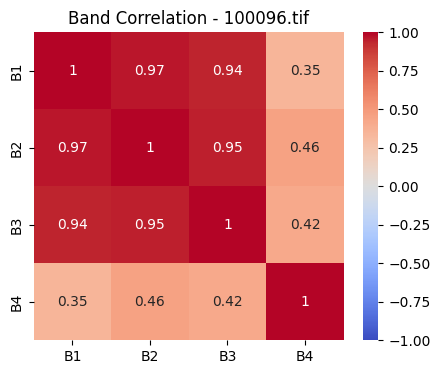

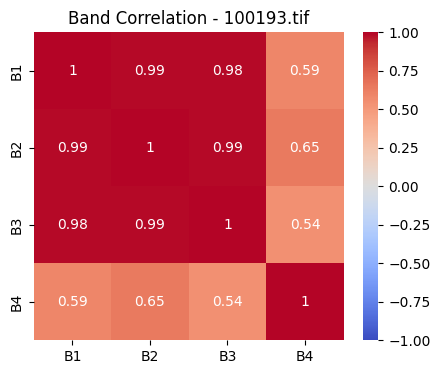

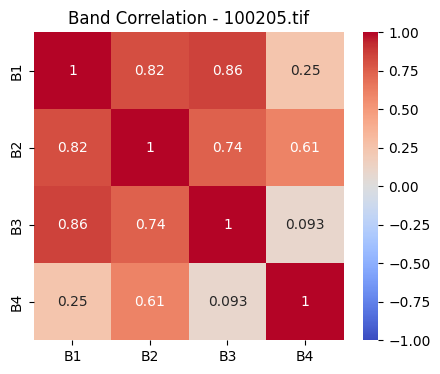

[          B1        B2        B3        B4
 B1  1.000000  0.965129  0.942701  0.348919
 B2  0.965129  1.000000  0.950262  0.457126
 B3  0.942701  0.950262  1.000000  0.418876
 B4  0.348919  0.457126  0.418876  1.000000,
           B1        B2        B3        B4
 B1  1.000000  0.986562  0.907420  0.216054
 B2  0.986562  1.000000  0.925737  0.287238
 B3  0.907420  0.925737  1.000000  0.206865
 B4  0.216054  0.287238  0.206865  1.000000,
           B1        B2        B3        B4
 B1  1.000000  0.991029  0.984401  0.586192
 B2  0.991029  1.000000  0.986578  0.646869
 B3  0.984401  0.986578  1.000000  0.542060
 B4  0.586192  0.646869  0.542060  1.000000,
           B1        B2        B3        B4
 B1  1.000000  0.818577  0.855463  0.245995
 B2  0.818577  1.000000  0.743263  0.607283
 B3  0.855463  0.743263  1.000000  0.092924
 B4  0.245995  0.607283  0.092924  1.000000,
           B1        B2        B3        B4
 B1  1.000000  0.996227  0.987758  0.991557
 B2  0.996227  1.000000  0.9

In [6]:
dataset_path = "/kaggle/input/cloud-masking-dataset/content/train"

data_dir = os.path.join(dataset_path, 'data')

# Get and sort image filenames
image_filenames = sorted([f for f in os.listdir(data_dir)])[:5]

def show_band_correlation(image_dir, image_files, num_samples=5):
    all_corrs = []

    for img_name in image_files[:num_samples]:
        img_path = os.path.join(image_dir, img_name)
        with rasterio.open(img_path) as src:
            image = src.read().astype(np.float32)  # shape: [4, H, W]

        # Reshape to [H*W, 4] for band-wise comparison
        h, w = image.shape[1], image.shape[2]
        pixels = image.reshape(4, -1).T  # shape: [H*W, 4]

        # Compute correlation matrix
        df = pd.DataFrame(pixels, columns=['B1', 'B2', 'B3', 'B4'])
        corr = df.corr()
        all_corrs.append(corr)

        # Plot correlation matrix
        plt.figure(figsize=(5, 4))
        sns.heatmap(corr, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
        plt.title(f'Band Correlation - {img_name}')
        plt.show()

    return all_corrs

show_band_correlation(data_dir,image_filenames)

# Image Filteration

In [7]:
import os
import numpy as np
from PIL import Image
import random
from pathlib import Path

def filter_image_files(image_dir, mask_dir, all_images):
    invalid = ['130726.tif','128206.tif','120337.tif','113390.tif','110139.tif','106892.tif',
     '156304.tif','148050.tif','144618.tif','140804.tif','140163.tif','136500.tif','136346.tif','132047.tif','131064.tif',
     '180089.tif','174809.tif','171789.tif','169591.tif','165308.tif','163182.tif','162823.tif','160718.tif',
     '196126.tif','195656.tif','191884.tif','185955.tif','185569.tif','185168.tif','182582.tif','182216.tif','181247.tif','180832.tif',
     '220031.tif','220020.tif','213000.tif','209167.tif','208304.tif','207241.tif','204721.tif',
     '236435.tif','235047.tif','233533.tif','233470.tif','229204.tif','225151.tif','223481.tif','220936.tif',
     '251631.tif','243423.tif',
     '280222.tif','278190.tif','276214.tif','264631.tif','262934.tif','262602.tif','261771.tif',
     '333752.tif','327408.tif','325595.tif','320800.tif','319869.tif','311740.tif','310647.tif','299836.tif','299836.tif','298561.tif','294760.tif','291134.tif','289430.tif','288128.tif',
     '390120.tif','389366.tif','385959.tif','385166.tif','382154.tif','363626.tif','356639.tif','355671.tif','343962.tif','342948.tif','340927.tif',
     '452457.tif','452058.tif','439498.tif','437477.tif','434132.tif','413118.tif','406461.tif','400692.tif','398910.tif',
     '501312.tif','498535.tif','496086.tif','485548.tif','477214.tif','476018.tif','475565.tif','469954.tif','465973.tif','462544.tif','462479.tif',
     '546157.tif','541315.tif','541314.tif','539486.tif','534303.tif','533377.tif','531641.tif','531589.tif','531262.tif','529161.tif','528728.tif','524723.tif','523808.tif','517885.tif','508548.tif','505910.tif','504630.tif',
     '588533.tif','585242.tif','577538.tif','574760.tif','573039.tif','567636.tif','567574.tif','563187.tif','558737.tif','556379.tif','550513.tif',
     '628027.tif','622669.tif','616780.tif','614426.tif','611945.tif','610626.tif','607259.tif','606957.tif','602248.tif','600318.tif',
     '690462.tif','690180.tif','688215.tif','684482.tif','673172.tif','673167.tif','664107.tif','659835.tif','658623.tif','646313.tif',
     '726495.tif','726258.tif','721826.tif','718115.tif','715870.tif','710754.tif','710434.tif','704238.tif','700534.tif','699573.tif',
     '766738.tif','766563.tif','760021.tif','757629.tif','757386.tif','749468.tif','742818.tif','741780.tif','738635.tif','737460.tif','730421.tif',
     '805477.tif','799565.tif','796353.tif','792232.tif','790017.tif','786128.tif','781725.tif','781121.tif','780999.tif','780432.tif','774225.tif','772561.tif','769983.tif',
     '845305.tif','843793.tif','836378.tif','831514.tif','825104.tif','823846.tif','811451.tif',
     '892313.tif','892170.tif','891662.tif','888939.tif','888669.tif','884616.tif','880360.tif','874668.tif','873048.tif','872882.tif','854213.tif','850435.tif',
     '953740.tif','951211.tif','950155.tif','947438.tif','946561.tif','938742.tif','938373.tif','936223.tif','934794.tif','933456.tif','930724.tif','929937.tif',
     '989173.tif','988811.tif','986486.tif','984642.tif','979988.tif','977340.tif','976303.tif','964915.tif','963245.tif','962529.tif','961186.tif','956360.tif',
     '127941.tif','309668.tif','898867.tif','830917.tif','280616.tif','219169.tif','283568.tif','999876.tif','998435.tif',
     '409913.tif','979727.tif','944193.tif','968524.tif','189982.tif','773452.tif','189982.tif','773452.tif','520040.tif','476009.tif','957915.tif','650607.tif',
     '684929.tif','636648.tif','788870.tif','764469.tif','285460.tif','315397.tif','682144.tif','521818.tif','373276.tif',
     '223928.tif','177941.tif','801432.tif','817552.tif','385192.tif','197966.tif',
     '430870.tif','802131.tif','427110.tif','100205.tif','268356.tif','628370.tif','360276.tif','480959.tif',
     '726667.tif','767578.tif','259097.tif','694587.tif','157105.tif',
     '867180.tif','848831.tif','502460.tif',
     '284430.tif','295408.tif','197429.tif','776234.tif','871934.tif','776234.tif','308314.tif',
     '379766.tif','727086.tif','474158.tif','929538.tif','293743.tif','144412.tif','651363.tif','259814.tif','163556.tif','356702.tif','309159.tif','132359.tif',



'178711.tif','139569.tif','120896.tif',
'987110.tif','987624.tif','988980.tif','989136.tif','992596.tif','992697.tif','993085.tif','996677.tif','999138.tif',
 '975373.tif','975804.tif','976566.tif','979940.tif','983687.tif',
 '962050.tif','966985.tif','970196.tif','970392.tif','974190.tif',
 '945328.tif','946335.tif','946721.tif','948612.tif','950083.tif','952631.tif','953025.tif','953452.tif','956721.tif','957091.tif','958179.tif',
 '933729.tif','936821.tif','936994.tif','938817.tif','940952.tif','943170.tif',
 '916776.tif','923532.tif','926403.tif','926867.tif','928381.tif','929912.tif','930958.tif','931016.tif',
 '903986.tif','904098.tif','904214.tif','904812.tif','905819.tif','907455.tif','907236.tif','910326.tif','911414.tif','912085.tif','913331.tif','913694.tif',
 '889743.tif','891638.tif','891952.tif','900771.tif','901164.tif','901677.tif','902575.tif',
 '877444.tif','879769.tif','881177.tif','882033.tif','884475.tif',
 '862182.tif','863214.tif','863611.tif','864654.tif','866437.tif','869735.tif','871051.tif','873207.tif','874415.tif','875679.tif',
 '848023.tif','848226.tif','851606.tif','855562.tif','855948.tif','860180.tif',
 '827968.tif','834861.tif','835716.tif','838083.tif','838857.tif','840282.tif','843788.tif',
 '818666.tif','818699.tif','819112.tif','820141.tif','820420.tif','820426.tif','824161.tif','827356.tif','827632.tif',
 '801062.tif','803904.tif','806215.tif','806537.tif','809621.tif','809794.tif','810029.tif','812597.tif','813536.tif',
 '820426.tif', '820141.tif', '819112.tif', '818666.tif', '815819.tif', '809621.tif', '803904.tif', '799143.tif', '797860.tif', '796982.tif',
 '793300.tif', '789365.tif', '785836.tif', '785611.tif', '782141.tif', '779378.tif', '778748.tif', '774734.tif', '774079.tif', '771088.tif', '768636.tif', '767033.tif', '765620.tif', 
 '762398.tif', '739037.tif', '753534.tif', '735242.tif', '733553.tif', '729057.tif', '721314.tif', '716338.tif', '714334.tif', '709908.tif', '708455.tif', '706005.tif', '702727.tif', '701987.tif',
 '698128.tif', '696152.tif', '677086.tif', '656968.tif', '656379.tif', '656011.tif', '650311.tif', '636521.tif', '636405.tif', '633469.tif', '629298.tif', '628313.tif',
 '617695.tif', '611994.tif', '611265.tif', '609845.tif', '609713.tif', '609232.tif', '608257.tif', '608205.tif', '601903.tif', '600811.tif', '598844.tif', '596489.tif', '591534.tif', '584045.tif', '583671.tif',
 '583000.tif', '575279.tif', '570622.tif', '566297.tif', '561101.tif', '549737.tif',
'532046.tif','499371.tif','497455.tif','491029.tif','489933.tif','483551.tif','476417.tif','455652.tif',
'452737.tif','451317.tif','445658.tif','443492.tif','433451.tif','429445.tif','428122.tif','427659.tif','416950.tif','413388.tif',
'279451.tif','281043.tif','282237.tif','285751.tif','286340.tif','287588.tif','288724.tif','290305.tif','290926.tif','291755.tif','295472.tif',
 '262816.tif','265759.tif','267099.tif','268752.tif','269087.tif','269654.tif','271241.tif','272892.tif','274389.tif','274421.tif',
 '239850.tif','243057.tif','244789.tif','247475.tif','252203.tif','253235.tif','255245.tif','256189.tif','256782.tif',
 '223050.tif','224357.tif','226882.tif','230192.tif','231165.tif','231414.tif','231647.tif','233051.tif','238976.tif',
 '204998.tif','207175.tif','208239.tif','210639.tif','211072.tif','213206.tif','214119.tif','214682.tif','215830.tif','216587.tif','218844.tif','221414.tif','221620.tif','221552.tif','221660.tif',
 '191962.tif','192337.tif','193471.tif','194682.tif','195643.tif','196407.tif','196973.tif','197793.tif','202344.tif','204441.tif',
 '170559.tif','172222.tif','178957.tif','178463.tif','178979.tif','180458.tif','189026.tif','189814.tif',
 '155164.tif','156413.tif','158845.tif','166175.tif','166645.tif','168458.tif','169465.tif',
 '137778.tif','139704.tif','143195.tif','148205.tif','152046.tif','152906.tif','153802.tif',
 '117711.tif','119264.tif','120669.tif','122056.tif','126135.tif','130216.tif','135527.tif',
 '101885.tif','102565.tif','102689.tif','109363.tif','111106.tif','113368.tif','114768.tif',
 '715332.tif','718372.tif','378428.tif','403387.tif','597732.tif','244775.tif','483542.tif'
]

    invalid_set = set(invalid)
    all_set =  set(all_images)
    valid_files = all_set - invalid_set
    print(f"Number of predefined invalid files: {len(invalid_set)}")

    # Step 2: Identify all-white masks
    all_white_masks = []
    for filename in valid_files:
        mask_path = os.path.join(mask_dir, filename)
        try:
            # Load mask as a numpy array
            mask = np.array(Image.open(mask_path))
            # Check if the mask is all-white (all pixels are 1 or 255)
            if np.all(mask == mask.max()) and mask.max() in [1, 255]:
                all_white_masks.append(filename)
        except Exception as e:
            print(f"Error loading mask {mask_path}: {e}")
            continue

    print(f"Number of all-white masks: {len(all_white_masks)}")

    final_valid_files = [f for f in valid_files if f not in all_white_masks]
    print(f"Number of final valid files: {len(final_valid_files)}")

    return final_valid_files


In [8]:
# Paths to your merged dataset
image_dir = '/kaggle/input/cloud-masking-dataset/content/train/data'
mask_dir = '/kaggle/input/cloud-masking-dataset/content/train/masks'

# Get list of all files (images)
all_images = os.listdir(image_dir)
filtered_images = filter_image_files(image_dir, mask_dir, all_images)
print(len(filtered_images))

Number of predefined invalid files: 595
Number of all-white masks: 2416
Number of final valid files: 7562
7562


# Data Augmentation

In [17]:
# Paths
augmented_image_dir = 'augmented/images'
augmented_mask_dir = 'augmented/masks'

os.makedirs(augmented_image_dir, exist_ok=True)
os.makedirs(augmented_mask_dir, exist_ok=True)

# Augmentation pipeline
augmentation = Compose([
    Resize(256, 256),
    HorizontalFlip(p=0.5),
    VerticalFlip(p=0.5),
    RandomRotate90(p=0.5),

])

AUG_PER_IMAGE = 3

def offline_augment_and_save(image_dir, mask_dir, image_files):
    for file_name in tqdm(image_files):
        img_path = os.path.join(image_dir, file_name)
        mask_path = os.path.join(mask_dir, file_name)

        # Read 4-channel image
        with rasterio.open(img_path) as src:
            image = src.read().astype(np.float32)
            image = np.transpose(image, (1, 2, 0))  # [H, W, 4]
            image = image[:, :, [0, 3]]             # Keep only bands 1 and 4 → shape [H, W, 2]

        # Read mask
        with rasterio.open(mask_path) as src:
            mask = src.read(1).astype(np.uint8)  # [H, W]

        for i in range(AUG_PER_IMAGE):
            augmented = augmentation(image=image, mask=mask)
            aug_image = augmented['image']
            aug_mask = augmented['mask']

            # Convert back to [C, H, W] for saving with rasterio
            aug_image_np = np.transpose(aug_image, (2, 0, 1)).astype(np.float32)
            aug_mask_np = aug_mask.astype(np.uint8)

            # Save image
            image_aug_path = os.path.join(augmented_image_dir, f"{file_name.replace('.tif', '')}_aug{i}.tif")
            with rasterio.open(
                image_aug_path, 'w',
                driver='GTiff',
                height=aug_image_np.shape[1],
                width=aug_image_np.shape[2],
                count=2,
                dtype=aug_image_np.dtype
            ) as dst:
                dst.write(aug_image_np)

            # Save mask
            mask_aug_path = os.path.join(augmented_mask_dir, f"{file_name.replace('.tif', '')}_aug{i}.tif")
            with rasterio.open(
                mask_aug_path, 'w',
                driver='GTiff',
                height=aug_mask_np.shape[0],
                width=aug_mask_np.shape[1],
                count=1,
                dtype=aug_mask_np.dtype
            ) as dst:
                dst.write(aug_mask_np, 1)
   

In [18]:
filtered_images = sorted(filtered_images)
# Split dataset: 80% train, 10% validation, 10% test
train_images, temp_images = train_test_split(filtered_images, test_size=0.2, random_state=42)
val_images, test_images = train_test_split(temp_images, test_size=0.5, random_state=42)

In [20]:
offline_augment_and_save(
    image_dir=image_dir,
    mask_dir=mask_dir,
    image_files=train_images,
)

augmented_images = sorted(os.listdir('augmented/images'))

100%|██████████| 8237/8237 [14:49<00:00,  9.26it/s]


# Data Leakage Check

In [21]:
import re   
         
train_set = set()  

for path in augmented_images:
    filename = os.path.basename(path)  # e.g., 'some_image_name_aug3.tif'
    match = re.match(r"(.+)_aug\d+\.tif", filename)
    if match:
        original_name = match.group(1) + ".tif"
        train_set.add(original_name)
        
# Convert to sets
val_set = set(val_images)
test_set = set(test_images)

# Check intersections
train_val_intersection = train_set & val_set
train_test_intersection = train_set & test_set
val_test_intersection = val_set & test_set

# Report
if train_val_intersection:
    print(f"Overlap between train and val: {len(train_val_intersection)} samples")
else:
    print("✅ No overlap between train and val")

if train_test_intersection:
    print(f"Overlap between train and test: {len(train_test_intersection)} samples")
else:
    print("✅ No overlap between train and test")

if val_test_intersection:
    print(f"Overlap between val and test: {len(val_test_intersection)} samples")
else:
    print("✅ No overlap between val and test")

✅ No overlap between train and val
✅ No overlap between train and test
✅ No overlap between val and test


# Data Loading

In [22]:
class CloudSegmentationDataset(Dataset):
    def __init__(self, image_dir, mask_dir, image_files, transform=None):
        self.image_dir = image_dir
        self.mask_dir = mask_dir
        self.image_files = image_files  
        self.transform = transform

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        img_name = self.image_files[idx]
        img_path = os.path.join(self.image_dir, img_name)
        mask_path = os.path.join(self.mask_dir, img_name) 

        # Load 4-band image: [4, H, W] → [H, W, 4]
        with rasterio.open(img_path) as src:
            image = src.read().astype(np.float32)
            image = np.transpose(image, (1, 2, 0))  # [H, W, 4]

        # Check if the image has 4 channels
        if image.shape[2] == 4:
            # Select the first and fourth channels (index 0 and 3)
            image = image[..., [0, 3]]  # [H, W, 2]
            
        # Load mask: [1, H, W] → [H, W]
        with rasterio.open(mask_path) as src:
            mask = src.read(1).astype(np.uint8)

        if self.transform:
            augmented = self.transform(image=image, mask=mask)
            image = augmented['image']
            mask = augmented['mask']

        mask = torch.tensor(mask, dtype=torch.long)

        return image, mask, img_name

In [23]:
train_dataset = CloudSegmentationDataset(image_dir='augmented/images', mask_dir='augmented/masks', image_files=augmented_images)
train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True)

In [24]:
val_test_transform = A.Compose([
    A.Resize(256, 256),
    ToTensorV2()
])

# Create DataLoader for Train, Validation, Test
val_dataset = CloudSegmentationDataset(image_dir=image_dir, mask_dir=mask_dir, image_files=val_images, transform=val_test_transform)
test_dataset = CloudSegmentationDataset(image_dir=image_dir, mask_dir=mask_dir, image_files=test_images, transform=val_test_transform)
all_dataset = CloudSegmentationDataset(image_dir=image_dir, mask_dir=mask_dir, image_files=filtered_images, transform=val_test_transform)

val_loader = DataLoader(val_dataset, batch_size=4, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=4, shuffle=False)
all_loader = DataLoader(all_dataset, batch_size=4, shuffle=False)

In [25]:
print(f"Train set size: {len(train_loader.dataset)}")
print(f"Validation set size: {len(val_loader.dataset)}")
print(f"Test set size: {len(test_loader.dataset)}")

Train set size: 24711
Validation set size: 1030
Test set size: 1030


In [26]:
print(f"all dataset size: {len(all_loader.dataset)}")

all dataset size: 10297


# Model Training

In [9]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"using {device}")

model = smp.DeepLabV3Plus(
    encoder_name="resnet34",       
    encoder_weights="imagenet",    
    in_channels=2,                 
    classes=1,                     
)

model.to(device)

using cuda
The history saving thread hit an unexpected error (OperationalError('attempt to write a readonly database')).History will not be written to the database.


config.json:   0%|          | 0.00/156 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/87.3M [00:00<?, ?B/s]

DeepLabV3Plus(
  (encoder): ResNetEncoder(
    (conv1): Conv2d(2, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=Tr

# Training Loop

Epoch 1/20:   0%|          | 0/6178 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)


419644_aug1.tif


Epoch 1/20:   0%|          | 1/6178 [00:03<5:15:05,  3.06s/it]

999924_aug2.tif


Epoch 1/20:   0%|          | 2/6178 [00:03<2:32:59,  1.49s/it]

970392_aug2.tif


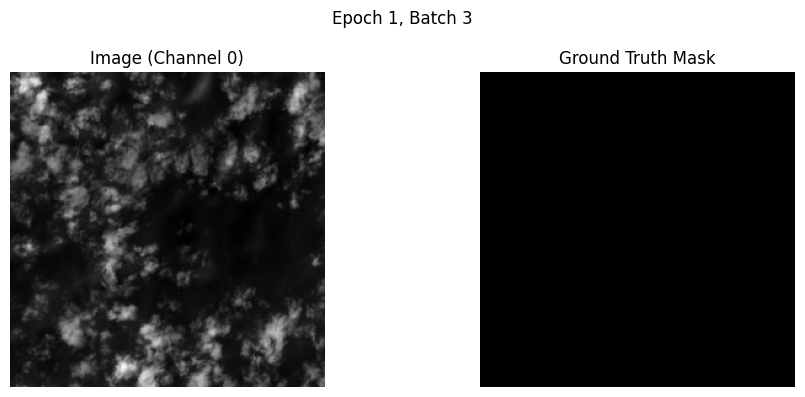

Epoch 1/20:   0%|          | 3/6178 [00:03<1:39:18,  1.04it/s]

224357_aug2.tif


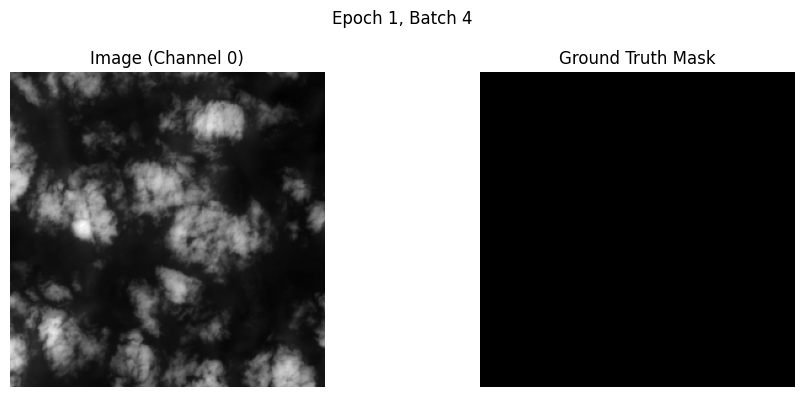

Epoch 1/20:   0%|          | 4/6178 [00:04<1:13:28,  1.40it/s]

112653_aug0.tif


Epoch 1/20:   0%|          | 5/6178 [00:04<59:22,  1.73it/s]  

620248_aug0.tif


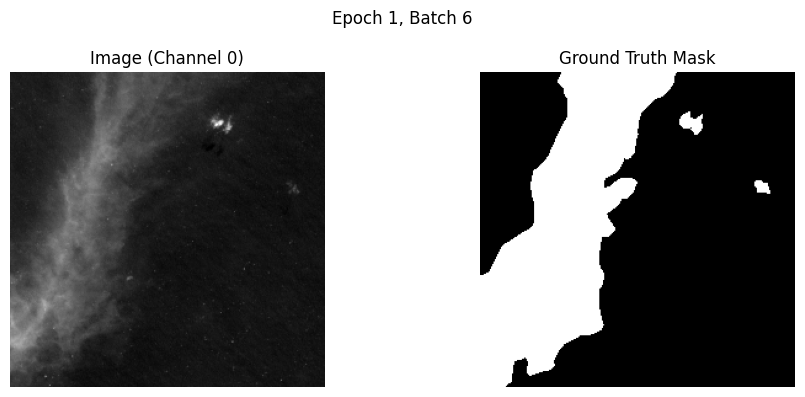

Epoch 1/20:   0%|          | 6/6178 [00:04<50:54,  2.02it/s]

179392_aug0.tif


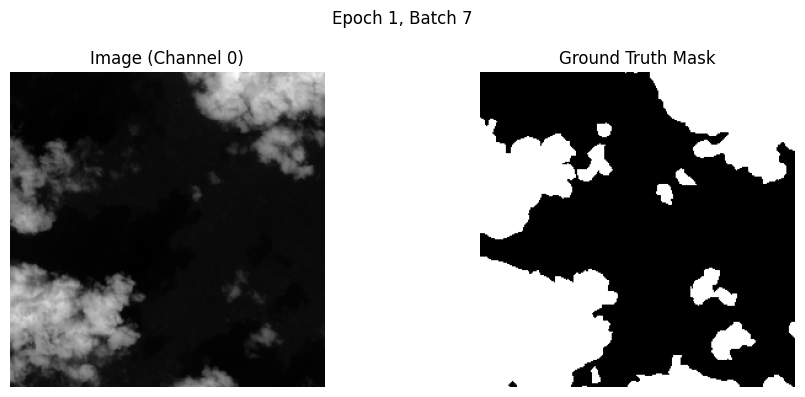

Epoch 1/20:   0%|          | 7/6178 [00:05<44:45,  2.30it/s]

609232_aug0.tif


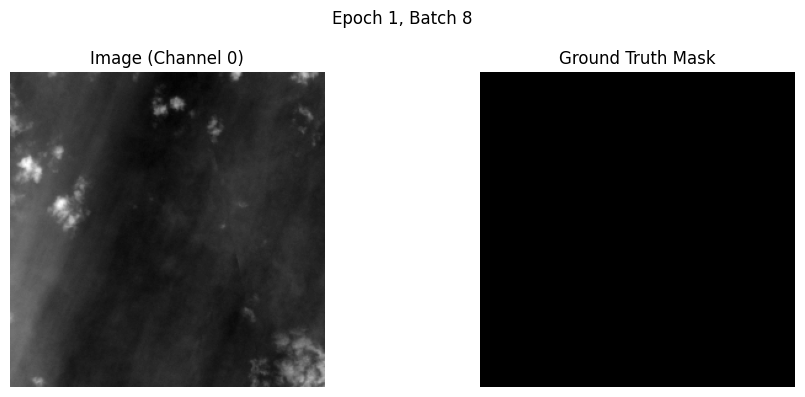

Epoch 1/20:   0%|          | 8/6178 [00:05<40:20,  2.55it/s]

157875_aug2.tif


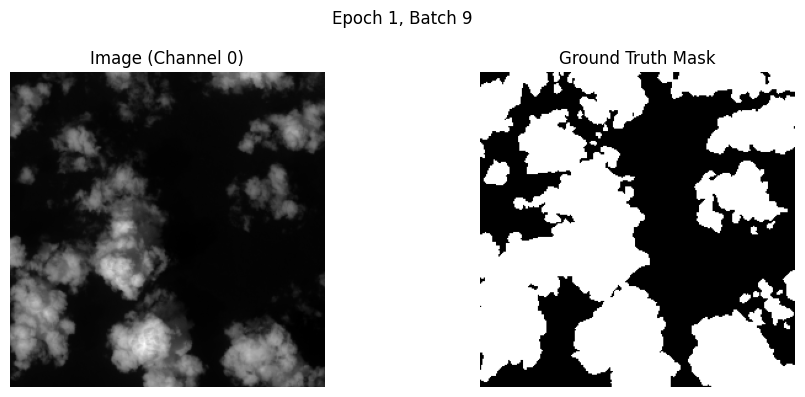

Epoch 1/20:   0%|          | 9/6178 [00:05<37:39,  2.73it/s]

771670_aug2.tif


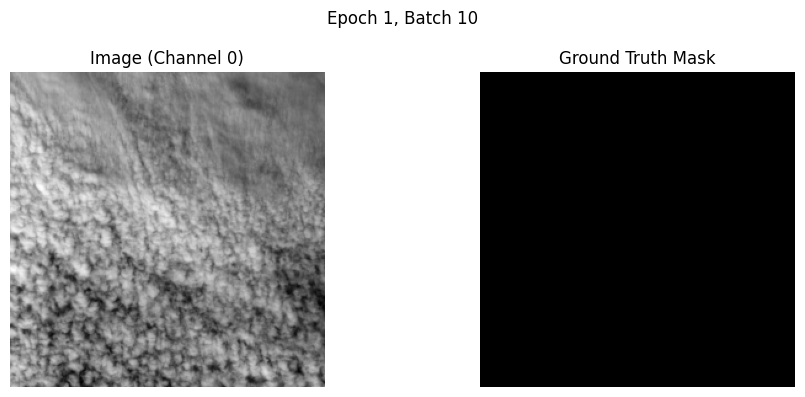

Epoch 1/20: 100%|██████████| 6178/6178 [09:56<00:00, 10.36it/s]
/tmp/ipykernel_31/1779026523.py:35: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  mask = torch.tensor(mask, dtype=torch.long)


Epoch [1/20], Loss: 0.3233
Validation Loss: 0.2120


Epoch 2/20: 100%|██████████| 6178/6178 [09:27<00:00, 10.88it/s]


Epoch [2/20], Loss: 0.2435
Validation Loss: 0.2134
Checkpoint saved at deeplabv3_ckpt_epoch_2.pth


Epoch 3/20: 100%|██████████| 6178/6178 [08:53<00:00, 11.57it/s]


Epoch [3/20], Loss: 0.2189
Validation Loss: 0.2006


Epoch 4/20: 100%|██████████| 6178/6178 [08:51<00:00, 11.63it/s]


Epoch [4/20], Loss: 0.2019
Validation Loss: 0.1958
Checkpoint saved at deeplabv3_ckpt_epoch_4.pth


Epoch 5/20: 100%|██████████| 6178/6178 [08:48<00:00, 11.69it/s]


Epoch [5/20], Loss: 0.1888
Validation Loss: 0.1927


Epoch 6/20: 100%|██████████| 6178/6178 [08:48<00:00, 11.70it/s]


Epoch [6/20], Loss: 0.1768
Validation Loss: 0.2405
Checkpoint saved at deeplabv3_ckpt_epoch_6.pth


Epoch 7/20: 100%|██████████| 6178/6178 [08:48<00:00, 11.69it/s]


Epoch [7/20], Loss: 0.1691
Validation Loss: 0.2205


Epoch 8/20: 100%|██████████| 6178/6178 [08:49<00:00, 11.66it/s]


Epoch [8/20], Loss: 0.1597
Validation Loss: 0.2234
Checkpoint saved at deeplabv3_ckpt_epoch_8.pth


Epoch 9/20: 100%|██████████| 6178/6178 [08:49<00:00, 11.66it/s]


Epoch [9/20], Loss: 0.1527
Validation Loss: 0.2383


Epoch 10/20: 100%|██████████| 6178/6178 [08:52<00:00, 11.61it/s]


Epoch [10/20], Loss: 0.1448
Validation Loss: 0.2241
Checkpoint saved at deeplabv3_ckpt_epoch_10.pth


Epoch 11/20: 100%|██████████| 6178/6178 [08:51<00:00, 11.62it/s]


Epoch [11/20], Loss: 0.1373
Validation Loss: 0.1943


Epoch 12/20: 100%|██████████| 6178/6178 [08:51<00:00, 11.63it/s]


Epoch [12/20], Loss: 0.1343
Validation Loss: 0.1985
Checkpoint saved at deeplabv3_ckpt_epoch_12.pth


Epoch 13/20: 100%|██████████| 6178/6178 [08:51<00:00, 11.63it/s]


Epoch [13/20], Loss: 0.1273
Validation Loss: 0.2171


Epoch 14/20: 100%|██████████| 6178/6178 [08:51<00:00, 11.61it/s]


Epoch [14/20], Loss: 0.1254
Validation Loss: 0.2303
Checkpoint saved at deeplabv3_ckpt_epoch_14.pth


Epoch 15/20: 100%|██████████| 6178/6178 [08:51<00:00, 11.61it/s]


Epoch [15/20], Loss: 0.1217
Validation Loss: 0.2074


Epoch 16/20: 100%|██████████| 6178/6178 [08:51<00:00, 11.62it/s]


Epoch [16/20], Loss: 0.1160
Validation Loss: 0.2134
Checkpoint saved at deeplabv3_ckpt_epoch_16.pth


Epoch 17/20: 100%|██████████| 6178/6178 [08:51<00:00, 11.62it/s]


Epoch [17/20], Loss: 0.1131
Validation Loss: 0.2033


Epoch 18/20: 100%|██████████| 6178/6178 [08:52<00:00, 11.60it/s]


Epoch [18/20], Loss: 0.1106
Validation Loss: 0.2000
Checkpoint saved at deeplabv3_ckpt_epoch_18.pth


Epoch 19/20: 100%|██████████| 6178/6178 [08:52<00:00, 11.60it/s]


Epoch [19/20], Loss: 0.1080
Validation Loss: 0.1950


Epoch 20/20: 100%|██████████| 6178/6178 [08:51<00:00, 11.63it/s]


Epoch [20/20], Loss: 0.1056
Validation Loss: 0.2209
Checkpoint saved at deeplabv3_ckpt_epoch_20.pth


In [29]:
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)
 
# Pick a test image filename from the test split
sample_test_image = test_images[5]  
sample_image_path = os.path.join(image_dir, sample_test_image)
sample_mask_path = os.path.join(mask_dir, sample_test_image)

# 6. Training Loop
num_epochs = 20
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    batch_idx = 0
    for images, masks, filename in tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}"):
        images = images.permute(0,3,1,2).to(device)
        masks = masks.to(device).unsqueeze(1).float()  # [B, 1, H, W]

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, masks)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        
        if epoch == 0 and batch_idx < 10:
            img = images[0].detach().cpu().permute(1, 2, 0).numpy()  # [H, W, C]
            mask = masks[0].squeeze().cpu().numpy()  # [H, W]

            if img.max() > 1.0:
                img = img / 255.0
                
            print(filename[0])
            plt.figure(figsize=(10, 4))

            plt.subplot(1, 2, 1)
            plt.imshow(img[:, :, 0], cmap='gray')  # Only show the first channel
            plt.title("Image (Channel 0)")
            plt.axis('off')

            plt.subplot(1, 2, 2)
            plt.imshow(mask, cmap='gray')
            plt.title("Ground Truth Mask")
            plt.axis('off')

            plt.suptitle(f"Epoch {epoch+1}, Batch {batch_idx+1}")
            plt.tight_layout()
            plt.show()
        batch_idx +=1

    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss/len(train_loader):.4f}")

    #  Validation
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for images, masks,_ in val_loader:
            images = images.to(device)
            masks = masks.to(device).unsqueeze(1).float()
            outputs = model(images)
            loss = criterion(outputs, masks)
            val_loss += loss.item()
    print(f"Validation Loss: {val_loss/len(val_loader):.4f}")

    if (epoch + 1) % 2 == 0:
        checkpoint_path = f"deeplabv3_ckpt_epoch_{epoch+1}.pth"
        torch.save(model.state_dict(), checkpoint_path)
        print(f"Checkpoint saved at {checkpoint_path}")

# 7. Save the trained model
torch.save(model.state_dict(), "deeplabv3.pth")

# Prediction

In [30]:
def dice_coefficient(pred, target):
    pred = pred.flatten()    
    target = target.flatten()         
    intersection = (pred * target).sum()
    return (2. * intersection) / (pred.sum() + target.sum() + 1e-8)

# rle enconding-decoding

In [31]:
import numpy as np
 
def rle_encode(mask):
    """
    Encodes a binary mask using Run-Length Encoding (RLE).
    
    Args:
        mask (np.ndarray): 2D binary mask (0s and 1s).
    
    Returns:
        str: RLE-encoded string.
    """
    pixels = mask.flatten(order='F')  # Flatten in column-major order
    pixels = np.concatenate([[0], pixels, [0]])  # Add padding to detect transitions
    runs = np.where(pixels[1:] != pixels[:-1])[0] + 1  # Get transition indices
    runs[1::2] -= runs[::2]  # Compute run lengths
    runs[::2] -= 1  # Make it 0-indexed instead of 1-indexed

    return " ".join(map(str, runs))  # Convert to string format

def rle_decode(mask_rle, shape):
    """
    Decodes an RLE-encoded string into a binary mask.
    
    Args:
        mask_rle (str): RLE-encoded string.
        shape (tuple): (height, width) of the output mask.
    
    Returns:
        np.ndarray: Decoded binary mask.
    """
    if not mask_rle:
        return np.zeros(shape, dtype=np.uint8)

    s = list(map(int, mask_rle.split()))
    starts, lengths = s[0::2], s[1::2]  # Separate start positions and lengths

    mask = np.zeros(shape[0] * shape[1], dtype=np.uint8)  # Create a flat mask
    for start, length in zip(starts, lengths):
        mask[start:start + length] = 1  # Fill mask with 1s

    return mask.reshape(shape, order='F')  # Reshape in column-major order


def generate_random_mask(shape, probability=0.5):
    """
    Generates a random binary mask.

    Args:
        shape (tuple): (height, width) of the mask.
        probability (float): Probability of a pixel being 1 (default is 0.5).

    Returns:
        np.ndarray: Random binary mask.
    """
    return (np.random.rand(*shape) < probability).astype(np.uint8)


if __name__ == "__main__":
    mask_shape = (9, 2)
    random_mask = generate_random_mask(mask_shape, probability=0.5)

    print("Random mask:")
    print(random_mask)

    rle_string = rle_encode(random_mask)
    print("\nRLE-encoded string:")
    print(rle_string)
    decoded_mask = rle_decode(rle_string, mask_shape)
    assert np.all(decoded_mask == random_mask), "Decoding is not the inverse of encoding!"

Random mask:
[[1 0]
 [0 1]
 [1 1]
 [1 1]
 [1 1]
 [0 1]
 [0 0]
 [1 0]
 [0 1]]

RLE-encoded string:
0 1 2 3 7 1 10 5 17 1


# Model Testing

In [57]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"using {device}")
# Load the trained model
model = smp.DeepLabV3Plus(
    encoder_name="resnet34",       
    encoder_weights="imagenet", 
    in_channels=2,                 
    classes=1,                     
)
model.load_state_dict(torch.load("/kaggle/working/deeplabv3_ckpt_epoch_18.pth", map_location=device))
model.to(device)

# Evaluate on test set
model.eval()
dice_scores = []
predictions_rle = []
ground_truth_rle = []
i = 0
with torch.no_grad():
    for image, mask,filenames in tqdm(test_loader, desc="Evaluating on test set"):
        image = image.to(device)
        output = model(image)

        output = torch.sigmoid(output).cpu().numpy()  # [B, 1, 512, 512]

        batch_size = output.shape[0]
        for idx in range(batch_size):
            # Process one sample at a time
            pred = output[idx, 0]  # [H, W]
            mask_np = mask[idx].cpu().numpy().astype(np.uint8)  # [H, W]

            pred_binary = (pred > 0.5).astype(np.uint8)
            dice = dice_coefficient(pred_binary, mask_np)

            filename = filenames[idx]
            image_id = filename.split(".")[0]
            dice_scores.append((dice,filename))

            predictions_rle.append({"id": image_id, "segmentation": rle_encode(pred_binary)})
            ground_truth_rle.append({"id": image_id, "segmentation": rle_encode(mask_np)})
        
            if idx==1 and i == 0:
                # Get the original 2-band image (first image in batch)
                full_image = image[idx].detach().cpu().numpy()  # [2, H, W]
            
                # Visualize first input channel only (as grayscale)
                display_image = full_image[0]  # channel 0
            
                if display_image.dtype != np.uint8:
                    display_image = (display_image - display_image.min()) / (display_image.max() - display_image.min()) * 255
                    display_image = display_image.astype(np.uint8)
            
                plt.figure(figsize=(12, 4))
            
                plt.subplot(1, 3, 1)
                plt.imshow(display_image, cmap='gray')
                plt.title('Input Channel 0')
                plt.axis('off')
            
                plt.subplot(1, 3, 2)
                plt.imshow(mask_np, cmap='gray')
                plt.title('Ground Truth')
                plt.axis('off')
            
                plt.subplot(1, 3, 3)
                plt.imshow(pred_binary, cmap='gray')
                plt.title(f'Prediction\nDice {dice:.4f}')
                plt.axis('off')
            
                plt.tight_layout()
                plt.show()

        i += 1

# Average Dice
average_dice = sum(dice for dice, _ in dice_scores) / len(dice_scores)
 
print(f"\nAverage Dice Coefficient on Test Set: {average_dice:.4f}")

using cuda


/tmp/ipykernel_31/414741608.py:10: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("/kaggle/working/deeplabv3_ckpt_epoch_18.pth", map_location

Evaluating on test set: 100%|██████████| 258/258 [00:27<00:00,  9.47it/s]


Average Dice Coefficient on Test Set: 0.8801


# View Low Dice Scores For Manual Filtration

108574.tif


496737.tif


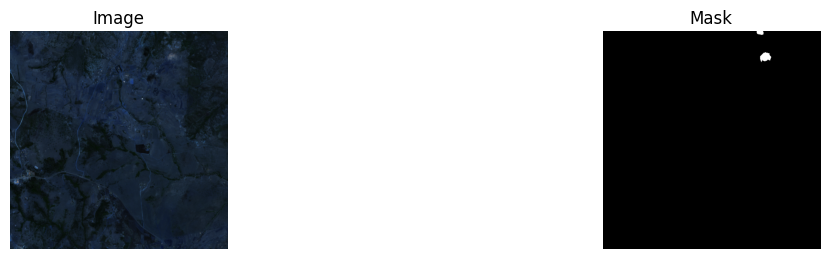

543555.tif


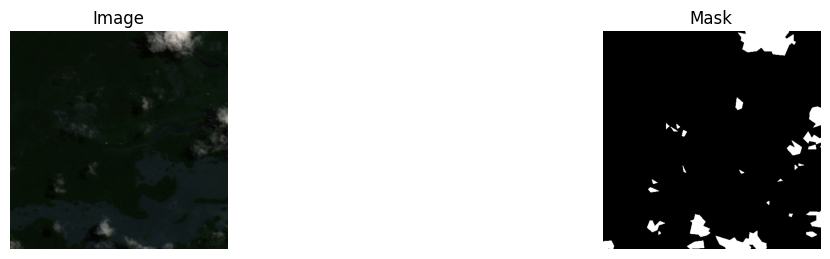

738221.tif


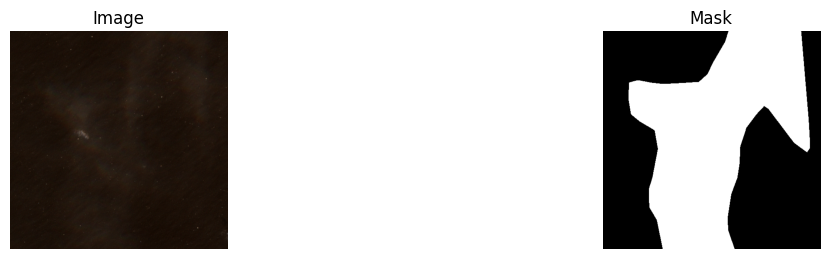

867541.tif


954987.tif


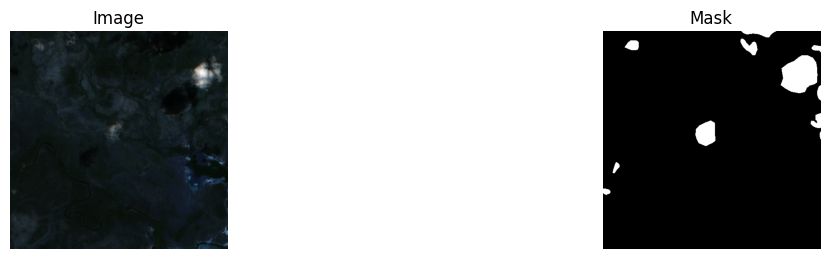

993916.tif


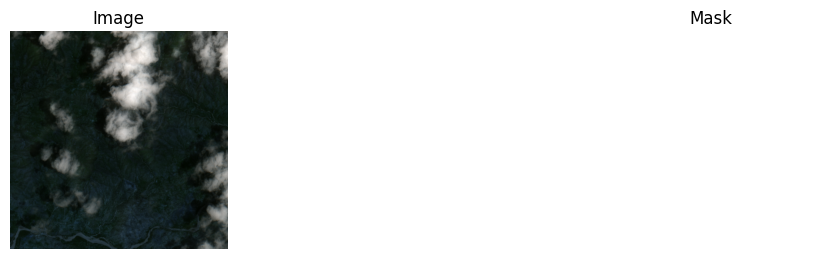

821024.tif


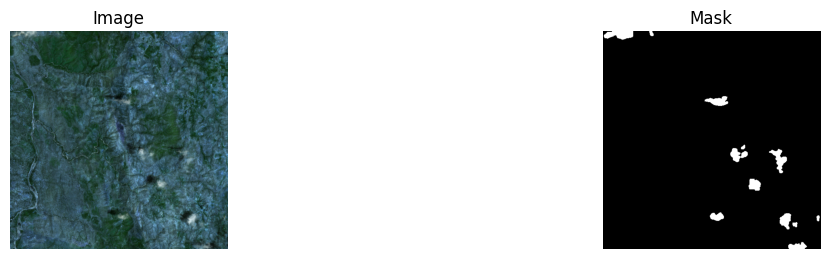

885386.tif


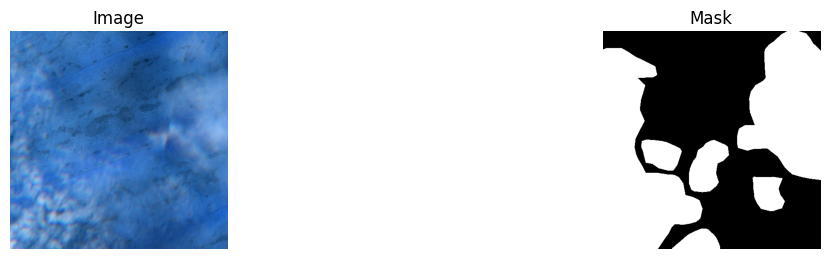

764442.tif


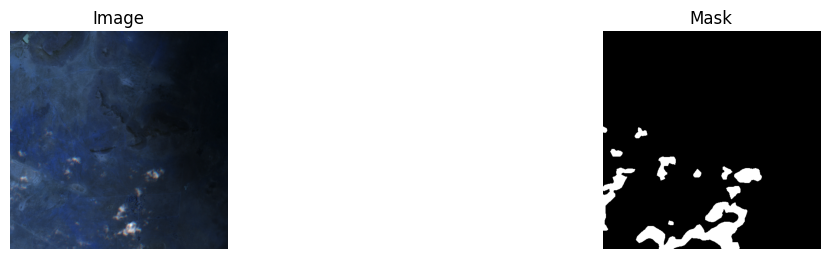

381342.tif


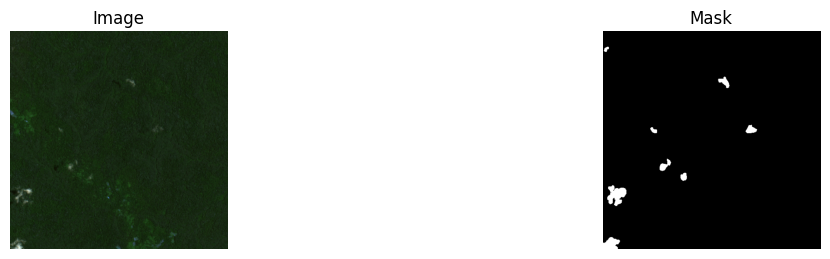

801520.tif


238353.tif


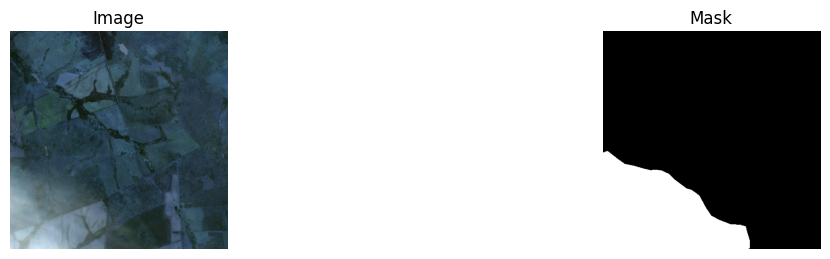

133796.tif


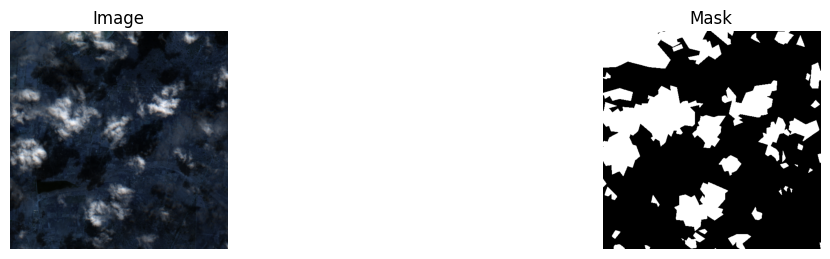

884170.tif


515287.tif


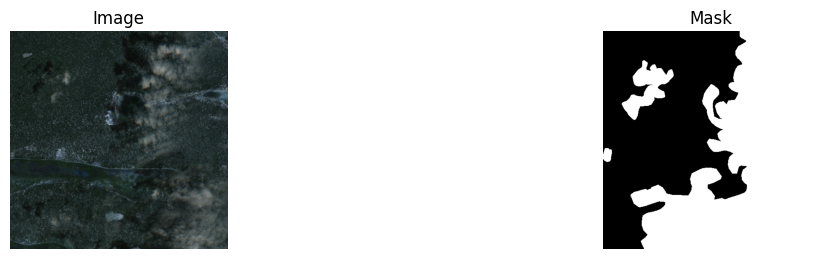

752011.tif


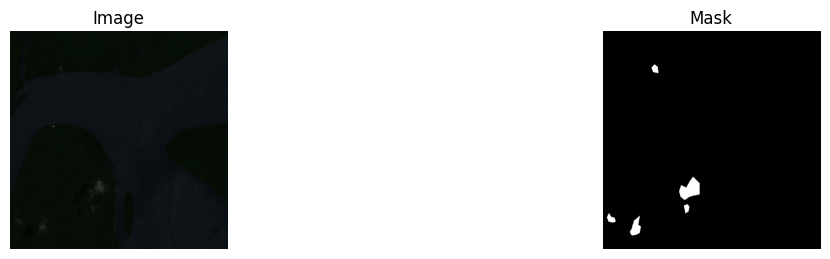

949363.tif


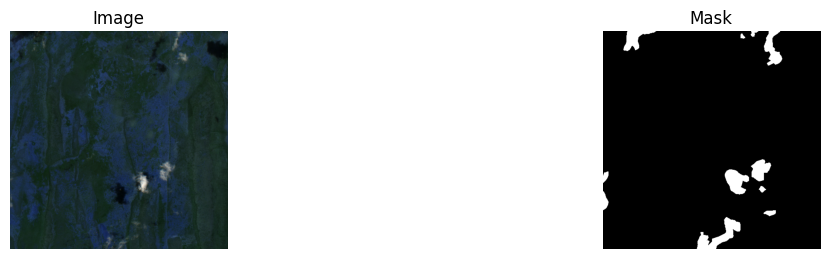

964749.tif


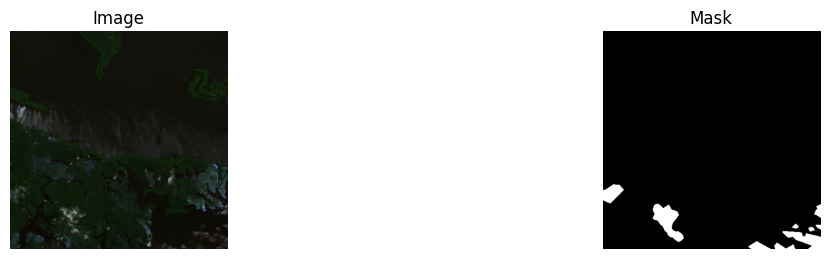

374921.tif


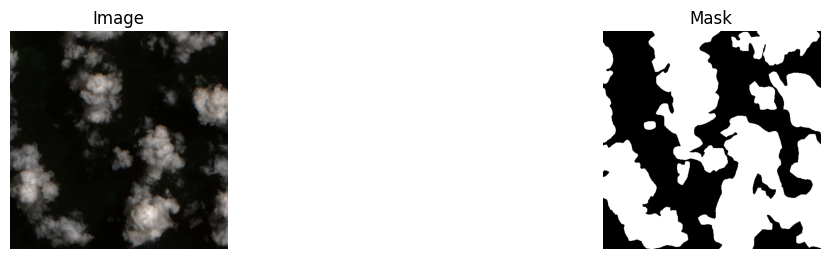

924718.tif


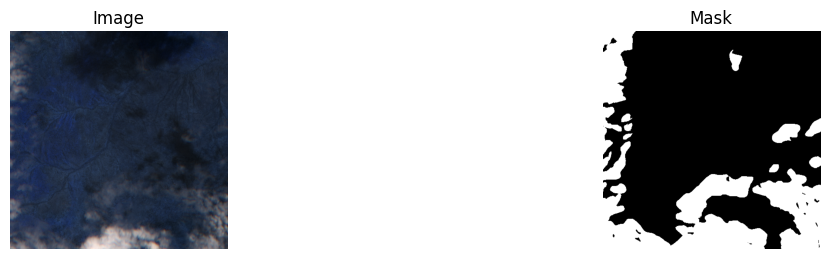

464663.tif


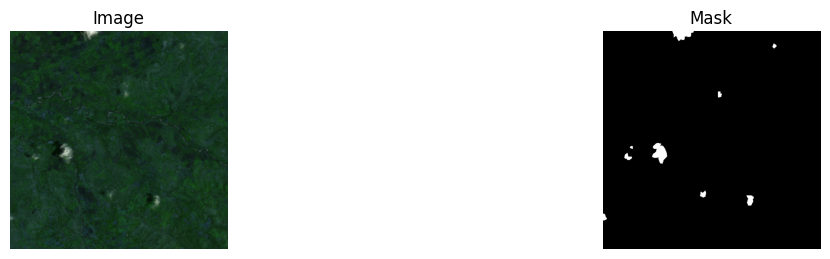

149840.tif


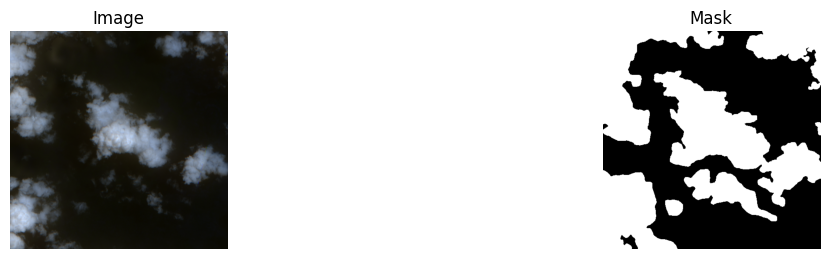

176517.tif


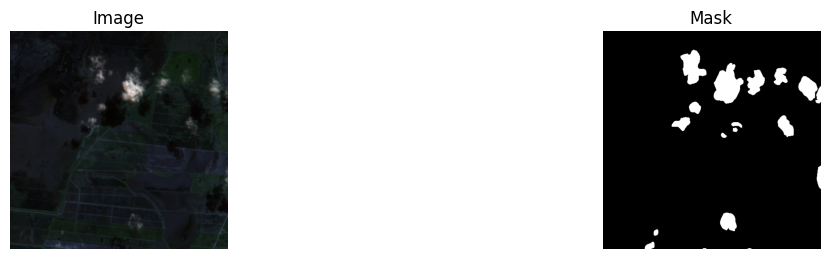

979789.tif


951327.tif


273148.tif


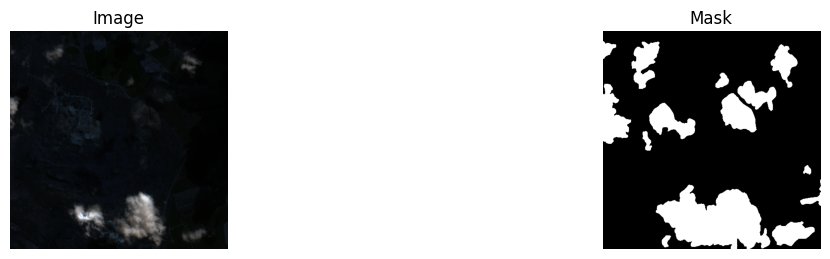

479580.tif


986593.tif


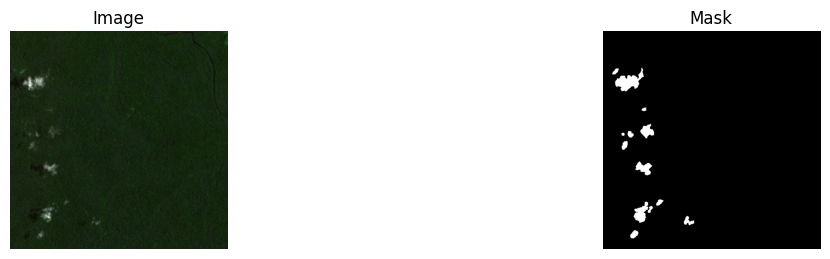

495648.tif


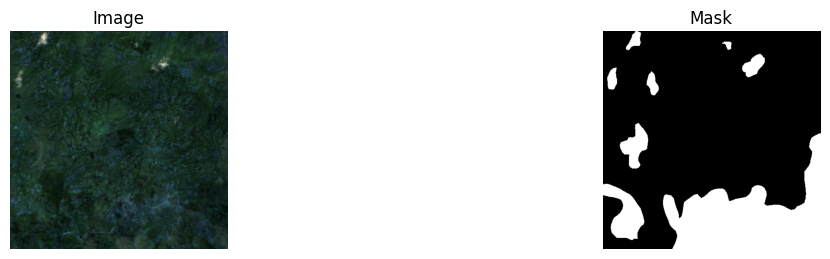

573639.tif


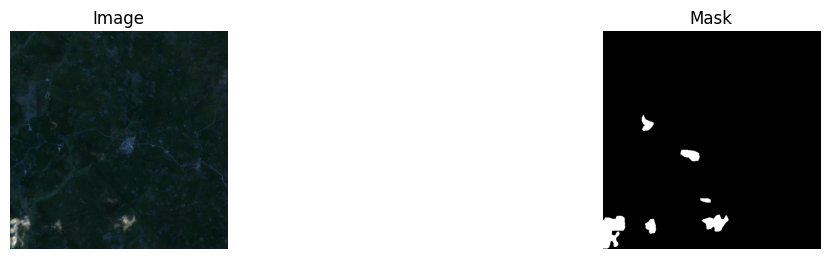

501936.tif


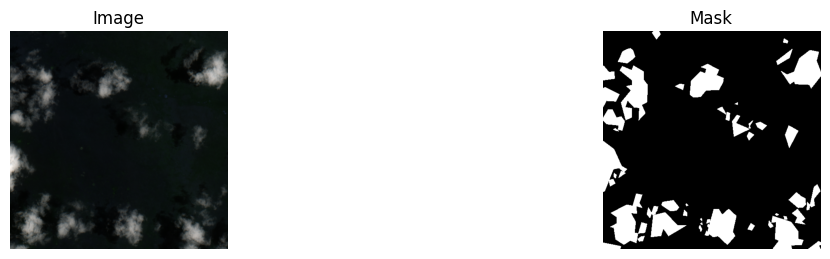

817659.tif


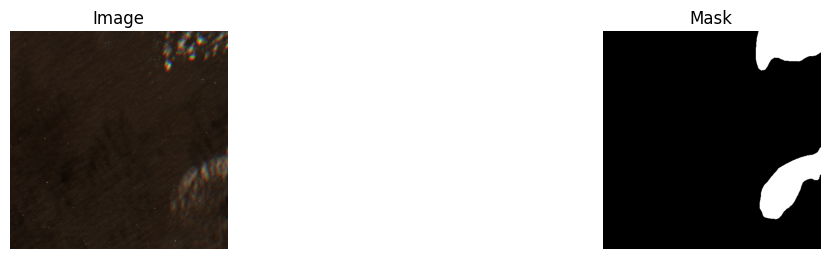

871523.tif


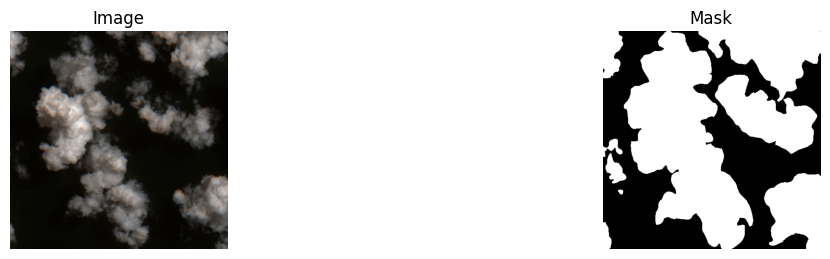

333210.tif


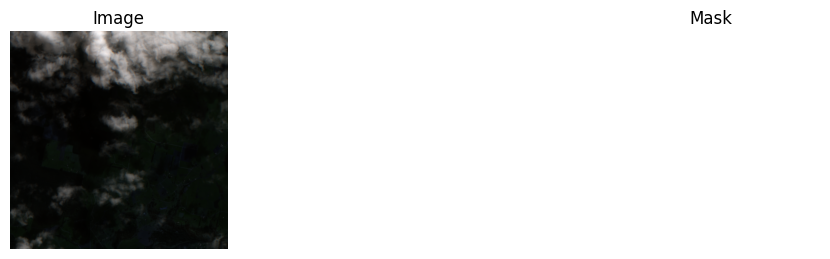

189083.tif


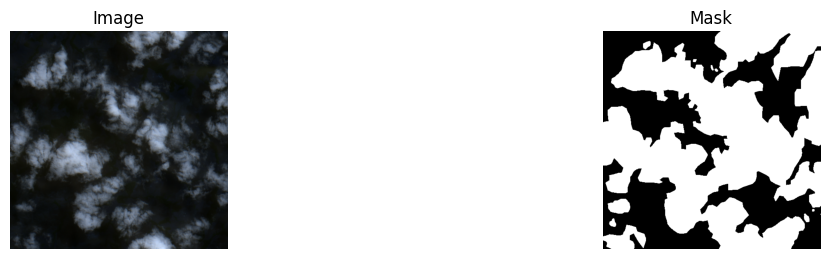

146853.tif


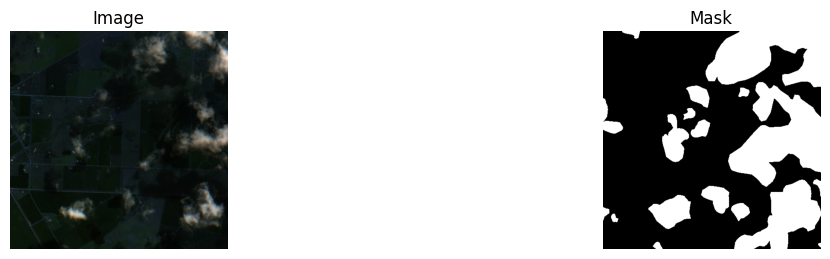

753064.tif


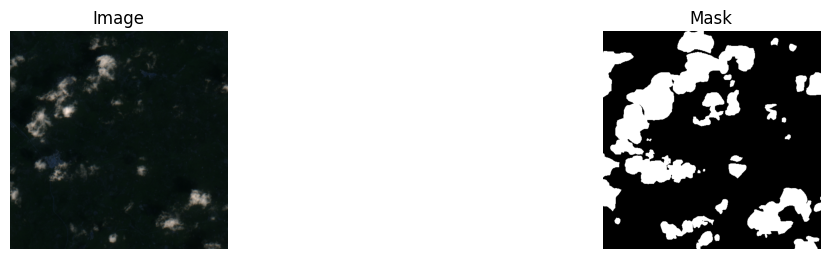

684056.tif


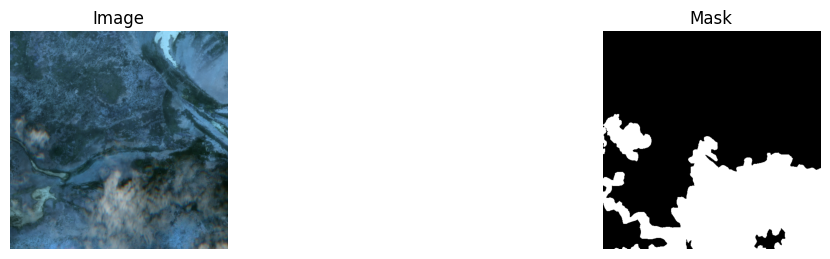

In [64]:
dice_sorted = sorted(dice_scores)
# Display image and mask pairs
  
for i,dice in enumerate(dice_sorted):
    if 80 < i < 120:
        dice_score,filename = dice
        print(filename)
        image_path = '/kaggle/input/cloud-masking-dataset/content/train/data/' + filename
        mask_path = '/kaggle/input/cloud-masking-dataset/content/train/masks/' + filename
        
        # Load image and mask
        image = tiff.imread(image_path)  # shape: (H, W, 4)
        mask = tiff.imread(mask_path)
        
        # Extract RGB channels only
        rgb_image = image[:, :,:3]
        # Normalize image if values are outside [0, 1] or [0, 255]
        if rgb_image.dtype != np.uint8:
            rgb_image = rgb_image.astype(np.float32)
            rgb_image = (rgb_image - rgb_image.min()) / (rgb_image.max() - rgb_image.min())
        
        plt.figure(figsize=(12, 12))
        # Plot RGB image
        plt.subplot(5, 2, 1)
        plt.imshow(rgb_image, cmap = 'gray')
        plt.title(f'Image')
        plt.axis('off')
        # Plot corresponding mask
        plt.subplot(5, 2, 2)
        plt.imshow(mask, cmap='gray', vmin=0, vmax=1)
        plt.title('Mask')
        plt.axis('off')
        # Extract RGB channels only
        rgb_image = image[:, :, :3]
        plt.tight_layout()
        plt.show()

# Evaluation

In [58]:
sol_df = pd.DataFrame(ground_truth_rle, columns=['id', 'segmentation'])

sol_df.to_csv('sol_df.csv', index=False)

pred_df = pd.DataFrame(predictions_rle, columns=['id', 'segmentation'])

pred_df.to_csv('pred_df.csv', index=False)

In [59]:
import pandas as pd
import numpy as np
import pandas.api.types


class ParticipantVisibleError(Exception):
    # If you want an error message to be shown to participants, you must raise the error as a ParticipantVisibleError
    # All other errors will only be shown to the competition host. This helps prevent unintentional leakage of solution data.
    pass


def rle_decode(mask_rle: str, shape=(256, 256)) -> np.ndarray:
    """Decodes an RLE-encoded string into a binary mask with validation checks."""
    
    try:
        s = list(map(int, mask_rle.split()))
    except:
        raise ParticipantVisibleError("RLE segmentation must contain only integers")
    
    if len(s) % 2 != 0:
        raise ParticipantVisibleError("RLE segmentation must have even-length (start, length) pairs")
    
    if any(x < 0 for x in s):
        raise ParticipantVisibleError("RLE segmentation must not contain negative values")
    
    mask = np.zeros(shape[0] * shape[1], dtype=np.uint8)
    starts, lengths = s[0::2], s[1::2]
    
    for start, length in zip(starts, lengths):
        if start >= mask.size or start + length > mask.size:
            raise ParticipantVisibleError("RLE indices exceed image size")
        mask[start:start + length] = 1
    
    return mask.reshape(shape, order='F')  # Convert to column-major order

def dice_coefficient(mask1: np.ndarray, mask2: np.ndarray) -> float:
    """Computes the Dice coefficient between two binary masks."""
    intersection = np.sum(mask1 * mask2)
    return (2.0 * intersection + 1e-7) / (np.sum(mask1) + np.sum(mask2) + 1e-7)  # Avoid division by zero

def score(solution: pd.DataFrame, submission: pd.DataFrame, row_id_column_name: str) -> float:
    """Computes the Dice score between solution and submission."""
    
    # Check if required columns exist
    required_columns = {row_id_column_name, "segmentation"}
    if not required_columns.issubset(solution.columns) or not required_columns.issubset(submission.columns):
        raise ParticipantVisibleError("Solution and submission must contain 'id' and 'segmentation' columns")
    
    # Ensure the IDs match between solution and submission
    if not solution[row_id_column_name].equals(submission[row_id_column_name]):
        raise ParticipantVisibleError("Submission IDs do not match solution IDs")
    
    # Delete the row ID column as Kaggle aligns solution and submission before passing to score()
    # del solution[row_id_column_name]
    # del submission[row_id_column_name]
    
    # Decode RLE masks and compute Dice score
    dice_scores = []
    for solution_seg, submission_seg in zip(solution["segmentation"], submission["segmentation"]):
        solution_mask = rle_decode(solution_seg)
        submission_mask = rle_decode(submission_seg)
        dice_scores.append(dice_coefficient(solution_mask, submission_mask))
    
    return np.mean(dice_scores)


In [60]:
scoree = score(sol_df,pred_df,'id') 
print(scoree)  

0.8800540758383996
